In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time, datetime
import data_wrangling as dw

#xgboost = gradientboosted tress
from sklearn.grid_search import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import chi2, SelectKBest, f_classif
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.svm import LinearSVC

In [25]:
def time_mask(df, key = 'Proc.Start.Date', value = '01/01/08'):
    t = time.mktime(datetime.datetime.strptime(value,'%d/%m/%y').timetuple())
    return df[key] >= t

In [26]:
def split_df(df):
    #mask = time_mask(df)
    
    #finalDf_train = df[-mask] # training 6000
    #finalDf_test = df[mask]   # training2 cros validation
    
    idx_val = pd.read_csv("data/training2_ids.csv")
    idx_holdout = pd.read_csv("data/testing_ids.csv")
    
    finalDf_test = df.loc[idx_val["ids"],:]
    #finalDf_train = munged.loc[~(munged.index).isin(idx_val["ids"])]
    finalDf_train = df.loc[(~(munged.index).isin(idx_val["ids"])) & (~(munged.index).isin(idx_holdout["ids"]))] 

    #creating X, y splits for test and train dataframes
    y_train = finalDf_train['Grant.Status'].values
    del finalDf_train['Grant.Status']
    del finalDf_train['Start.date']
    X_train = finalDf_train.values

    y_test = finalDf_test['Grant.Status'].values
    del finalDf_test['Grant.Status']
    del finalDf_test['Start.date']
    X_test = finalDf_test.values

    return X_train, y_train, X_test, y_test, finalDf_test, finalDf_train

In [27]:
def dataset_holdout(df):
    idx_holdout = pd.read_csv("data/testing_ids.csv")
    finalDf_holdout = df.loc[idx_holdout["ids"],:]
    
    y_holdout = finalDf_holdout['Grant.Status'].values
    del finalDf_holdout['Grant.Status']
    del finalDf_holdout['Start.date']
    X_holdout = finalDf_holdout.values

    return X_holdout, y_holdout

In [28]:
orig = dw.get_tables()
munged = dw.munge_data(orig)
X_train, y_train, X_test, y_test, finalDf_test, finalDf_train = split_df(munged)
X_holdout, y_holdout = dataset_holdout(munged)

/home/charles/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2821: DtypeWarning: Columns (90,105,119,120,123,124,132,134,135,138,139,147,149,150,153,154,162,164,165,168,169,177,179,183,184,192,194,198,199,207,209,213,214,224,237,239,244) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):
/home/charles/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2881: DtypeWarning: Columns (90,105,119,120,123,124,132,134,135,138,139,147,149,150,153,154,162,164,165,168,169,177,179,183,184,192,194,198,199,207,209,213,214,224,237,239,244) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/charles/Desktop/DSR/mini-competition/data_wrangling2.py:63: RuntimeWarning: invalid value encountered in double_scalars
  x[i] = 2017 - (np.nansum(tmp_df3.iloc[i, :]) / (16 - nan_ctr))


In [29]:
def training(X, y, X_test = None, y_test = None, a = None):
    if(a != None):
        train_labels = np.arange(X.shape[0])
        test_labels = np.arange(X_test.shape[0]) + X.shape[0]
        X = np.concatenate((X, X_test), axis = 0)
        y = np.concatenate((y, y_test), axis = 0)
        cv_custom = [(train_labels, test_labels)]
    estimators = [
            ('scale_predictors', StandardScaler()),
            #('feature_selector', LinearSVC(penalty='l1', dual=False)),
            #('feature_selector', SelectKBest(score_func=f_classif)),
            #('linearSVC', LinearSVC())
            ('randomforests', RandomForestClassifier())
            ]
    clf = Pipeline(estimators)
    params = dict(
            #linearSVC__C=[0.1, 1, 10],
            randomforests__max_depth=[5, 10, None], 
            randomforests__n_estimators=[10, 50, 100,1000,10000], 
            #feature_selector__C=[0.1, 1, 10]
            #feature_selector__score_func=[chi2],
            #feature_selector__k=[5, 10, 'all'] 
            )
    if(a != None):
        grid_search = GridSearchCV(clf, param_grid=params, cv=cv_custom, scoring = 'roc_auc', n_jobs = 6)
    else:
        grid_search = GridSearchCV(clf, param_grid=params, scoring = 'roc_auc', n_jobs = 6)
    grid_search.fit(X, y)
    return grid_search

In [30]:
def performance(results, param1, param2):
    param1_vals = [x.parameters[param1] for x in results.grid_scores_]
    param2_vals = [x.parameters[param2] for x in results.grid_scores_]
    means = [x.mean_validation_score for x in results.grid_scores_]
    df = pd.DataFrame(list(zip(param1_vals, param2_vals, means)), columns = [param1, param2, 'means'])
    df.fillna('None', inplace=True)
    return pd.pivot_table(df, values = 'means' , index = param1, columns = param2)

In [9]:
%matplotlib inline

%pylab

import matplotlib.pyplot as plt

plt.close('all')
pylab.rcParams['figure.figsize'] = (30.0, 30.0)

offset = 12*0
n = 24
cols = 3
myrange = finalDf_train.columns[list(range(6))+list(range(10, 14))+list(range(15, 20))+[37, 38, 42, 58, 63, 68, 69, 70, 76]]
fig, sbp = plt.subplots(n//cols, cols)
fig.tight_layout()
for i, l in enumerate(myrange[offset:offset+n]):
    #print(i,l)
    sbp[i //cols][i % cols].set_title('{}: '.format(i+offset)+l, size=30)
    finalDf_train[l].hist(ax=sbp[i //cols ][i % cols], bins = 30)

Using matplotlib backend: Qt5Agg
Populating the interactive namespace from numpy and matplotlib


In [31]:
selector = SelectKBest(f_classif, k=60)
selector.fit(X_train, y_train)
scores = -np.log10(selector.pvalues_)

X_best = X_train[:, selector.get_support()]
X_best_test = X_test[:, selector.get_support()]
X_best_holdout = X_holdout[:, selector.get_support()]
a = np.where(selector.get_support()==True)
scores_k = scores[a]

mn = munged.copy()
#munged = dw.munge_data(orig)
del mn['Grant.Status']
best_kcols = mn.columns[a]
#BetsCols = list(zip(best_kcols, scores_k))
BestCols = np.stack((scores_k, best_kcols), axis=1)
#munged = dw.munge_data(orig)

BestCols[np.argsort(BestCols[:,0],)[::-1]]

/home/charles/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [31 56] are constant.
  UserWarning)
/home/charles/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


array([[99.99810793145086, '50A'],
       [75.33491219529495, 'Contract.Value.Band...see.note.A'],
       [71.65567722045532, 'Number.of.Successful.Grant.1'],
       [43.71242577338992, 'C.1'],
       [36.15095593326157, '30A'],
       [24.950918125108146, 'Number.of.Unsuccessful.Grant.1'],
       [18.44548036859305, 'PRINCIPAL_SUPERVISOR'],
       [14.95545625701007, '40C'],
       [14.808990104357184, 'SEO.Code._72.0'],
       [13.188856809631888, 'RFCD.Code._31.0'],
       [11.423064700781278, '% Australians'],
       [9.437693239506702, 'Nb_Phd'],
       [6.440561858711821, 'RFCD.Code._33.0'],
       [5.793846222932014, 'SEO.Code._76.0'],
       [5.776419865427003, 'SEO.Code._-0.0'],
       [5.238675573420342, 'STUD_CHIEF_INVESTIGATOR'],
       [5.1244367077475825, '30B'],
       [5.025678603534492, 'A.1'],
       [4.901010689159404, '30F'],
       [4.147669770910852, 'A..1'],
       [3.879956866527504, 'RFCD.Code._41.0'],
       [3.5863837187886487, 'RFCD.Code._34.0'],
       [3.5

In [32]:
#model_on_train = training(X_train, y_train)
model_on_train = training(X_best, y_train, X_test=X_best_test, y_test=y_test, a = 2)
model_on_train.best_score_
#model_on_test.best_score_
a = list(model_on_train.param_grid)
train_results = performance(model_on_train, a[0],  a[1])
#a = list(model_on_test.param_grid)
#test_results = performance(model_on_test, a[0],  a[1])
print(train_results)
#print(test_results)
# can only take 2 variables for our pivot table

randomforests__n_estimators     10        50        100       1000      10000
randomforests__max_depth                                                     
5.0                          0.795823  0.881362  0.885372  0.889224  0.885354
10.0                         0.877329  0.892303  0.901663  0.907859  0.908631
None                         0.860352  0.903236  0.904900  0.909482  0.910661


In [33]:
y_pred = model_on_train.best_estimator_.predict(X_best_holdout)
y_score = model_on_train.best_estimator_.predict_proba(X_best_holdout)
np.sum(y_holdout == y_pred)/len(y_holdout)
#y_score[:,1].ravel()

0.86872586872586877

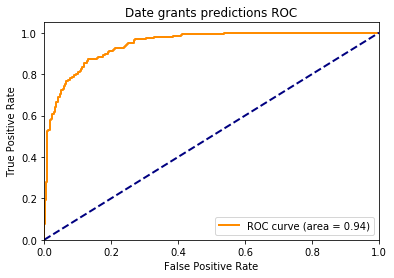

In [34]:
from sklearn.metrics import roc_curve, auc
%matplotlib inline

fpr, tpr, thd = roc_curve(y_holdout.ravel(), y_score[:,1].ravel())
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Date grants predictions ROC')
plt.legend(loc="lower right")
plt.show()